In [1]:
from portfolio_optimization.data_processing import *
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
from tokens.get_assets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, plotting

In [2]:
asset_list = get_tickers()
_df = get_historical_prices_for_assets(asset_list['high_risk_tickers'], time_range=timedelta(days=365 * 3), interested_columns=["ReferenceRate", "CapMrktEstUSD"])

# Filter out all columns containing `_` in their name
df = _df.loc[:, ~_df.columns.str.contains("_")]

# Get all the market caps
mcaps = _df.loc[:, _df.columns.str.contains("CapMrktEstUSD")]
mcaps.columns = mcaps.columns.str.replace("_CapMrktEstUSD", "")
mcaps.replace(np.nan, 0, inplace=True)
# Print comprehensive statistical summary
df

High risk tickers: 12
Medium risk tickers: 60
Low risk tickers: 8


/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/data_collection/get_crypto_price_range.py:41: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/d2/1qh2h9ys19z3375prb_0cb8w0000gn/T/ipykernel_91239/3080830945.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcaps.replace(np.nan, 0, inplace=True)


,btc,ada,link,eth,cake,bnb,uni,dot,aave,matic,sol,avax
2020-08-06,11721.438472,0.142568,9.555347,400.601196,NaN,23.254875,NaN,NaN,NaN,0.021394,1.769735,NaN
2020-08-07,11769.309108,0.143620,10.047598,393.995932,NaN,22.734751,NaN,NaN,NaN,0.021742,2.208250,NaN
2020-08-08,11598.969059,0.139262,10.016445,380.330054,NaN,22.242044,NaN,NaN,NaN,0.021407,2.071153,NaN
2020-08-09,11743.008635,0.145932,12.766904,392.360177,NaN,22.855079,NaN,NaN,NaN,0.022851,2.473308,NaN
2020-08-10,11680.517366,0.144751,13.854406,389.183157,NaN,22.393113,NaN,NaN,NaN,0.022750,2.677602,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-02,29499.587539,0.309169,7.606753,1866.989851,1.543897,247.054660,6.659183,5.187587,65.356726,0.697381,23.898541,12.838517
2023-08-03,29143.151962,0.299009,7.345212,1838.295086,1.510012,240.534117,6.145863,5.052277,64.620255,0.680171,23.146745,12.522736
2023-08-04,29192.344862,0.292540,7.130417,1835.916255,1.508193,241.114310,6.110497,4.983120,63.080102,0.668398,22.666490,12.446276
2023-08-05,29057.253244,0.293362,7.127077,1826.273583,1.501539,241.316343,6.046999,4.986903,64.064412,0.663399,22.791506,12.389208


,btc,ada,link,eth,cake,bnb,uni,dot,aave,matic,sol,avax
btc,1.000000,0.821516,0.811645,0.840760,0.775200,0.723083,0.837930,0.934413,0.822136,0.496734,0.664349,0.662243
ada,0.821516,1.000000,0.774874,0.834208,0.850954,0.721200,0.832627,0.854203,0.803523,0.605733,0.720501,0.584472
link,0.811645,0.774874,1.000000,0.586646,0.933629,0.461759,0.935754,0.911042,0.936412,0.227967,0.436329,0.415886
eth,0.840760,0.834208,0.586646,1.000000,0.649514,0.904616,0.629178,0.772073,0.586623,0.832771,0.874997,0.827560
cake,0.775200,0.850954,0.933629,0.649514,1.000000,0.720454,0.940041,0.833836,0.924775,0.257739,0.414513,0.311570
bnb,0.723083,0.721200,0.461759,0.904616,0.720454,1.000000,0.586047,0.665091,0.465528,0.832034,0.740112,0.713355
uni,0.837930,0.832627,0.935754,0.629178,0.940041,0.586047,1.000000,0.895347,0.953949,0.290373,0.395846,0.346980
dot,0.934413,0.854203,0.911042,0.772073,0.833836,0.665091,0.895347,1.000000,0.866008,0.425533,0.671281,0.628751
aave,0.822136,0.803523,0.936412,0.586623,0.924775,0.465528,0.953949,0.866008,1.000000,0.220694,0.345251,0.336770
matic,0.496734,0.605733,0.227967,0.832771,0.257739,0.832034,0.290373,0.425533,0.220694,1.000000,0.761241,0.737033


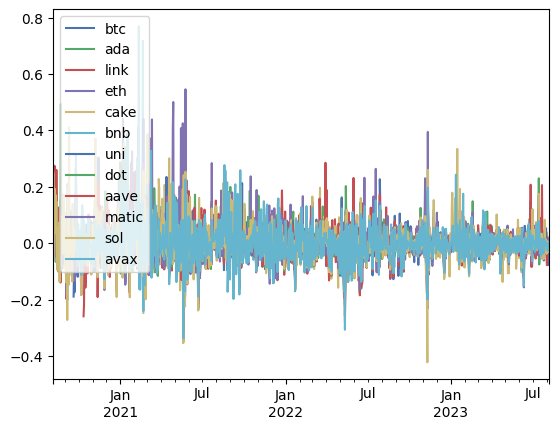

In [3]:
# this will give you the percentage change
df_percentage_variation = df.pct_change()

# plot variation of each asset's price
df_percentage_variation.plot()
pd.DataFrame(df).corr()

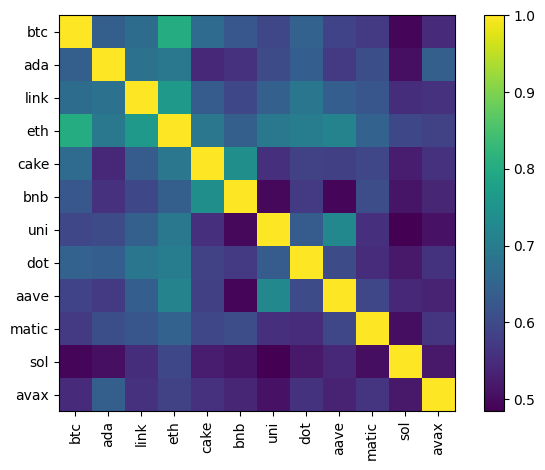

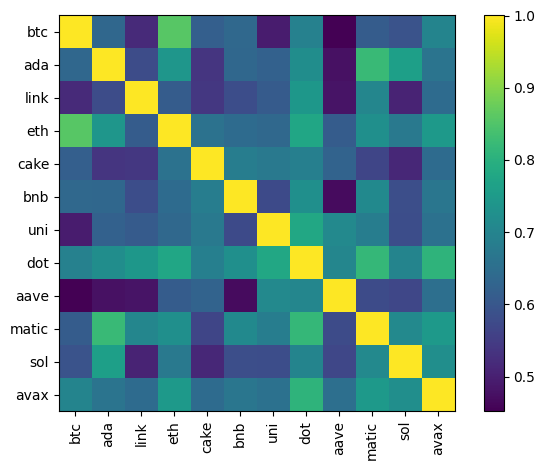

In [4]:
past_df, future_df = df.iloc[:-100], df.iloc[-100:]
future_cov = risk_models.sample_cov(future_df).fillna(0)
sample_cov = risk_models.sample_cov(past_df).fillna(0)

plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [5]:
rets = expected_returns(df)
rets.tail()

,btc,ada,link,eth,cake,bnb,uni,dot,aave,matic,sol,avax
2023-08-02,0.009575,0.005891,0.007970,0.005821,-0.005227,0.024375,0.018497,0.015490,0.000355,0.014098,0.007125,0.001194
2023-08-03,-0.012083,-0.032862,-0.034383,-0.015370,-0.021948,-0.026393,-0.077085,-0.026083,-0.011268,-0.024678,-0.031458,-0.024596
2023-08-04,0.001688,-0.021633,-0.029243,-0.001294,-0.001205,0.002412,-0.005754,-0.013688,-0.023834,-0.017309,-0.020748,-0.006106
2023-08-05,-0.004628,0.002810,-0.000468,-0.005252,-0.004412,0.000838,-0.010392,0.000759,0.015604,-0.007479,0.005515,-0.004585
2023-08-06,-0.000143,0.000275,0.013234,0.004987,-0.005126,0.006632,0.005281,-0.003719,0.004363,0.004346,-0.008062,0.003079


In [6]:
# exp_cov = risk_models.exp_cov(past_df)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(future_cov, plot_correlation=True)
# plt.show()

Optimization
================

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/black_litterman.py:159: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


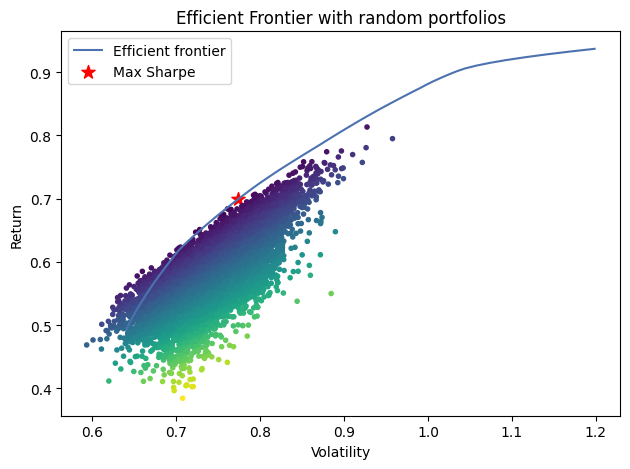

Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1


In [7]:
from portfolio_optimization.optimization.hrp import HRPOptimization
from portfolio_optimization.optimization.markowitz import Markowitz
from portfolio_optimization.optimization.black_litterman import BlackLitterman
from portfolio_optimization.optimization.risk_parity import RiskParity
from portfolio_optimization.optimization.heuristic import FastRiskParity, Heuristic, RewardToRisk, VolatilityOfVolatility, ValueAtRisk, RewardToVaR, Combination, SimpleVolatility
hrp = HRPOptimization(df, rets=rets)
hrp_weights = hrp.get_weights()

markowitz = Markowitz(df)
markowitz_weights = markowitz.get_weights()

last_mcaps = mcaps.iloc[-2]

bl = BlackLitterman(df, mcaps=last_mcaps)
bl_weights = bl.get_weights()
bl.plot_frontier()

rp = RiskParity(df)
rp_weights = rp.get_weights()

fast_rp = FastRiskParity(df)
fast_rp_weights = fast_rp.get_weights()

rtr = RewardToRisk(df)
rtr_weights = rtr.get_weights()

vov = VolatilityOfVolatility(df)
vov_weights = vov.get_weights()

vo = SimpleVolatility(df)
vo_weights = vo.get_weights()

var = ValueAtRisk(df)
var_weights = var.get_weights()

rtvar = RewardToVaR(df)
rtvar_weights = rtvar.get_weights()

combination = Combination(df)
combination_weights = combination.get_weights()

heuristic = Heuristic(df)
heuristic_weights = heuristic.get_weights()

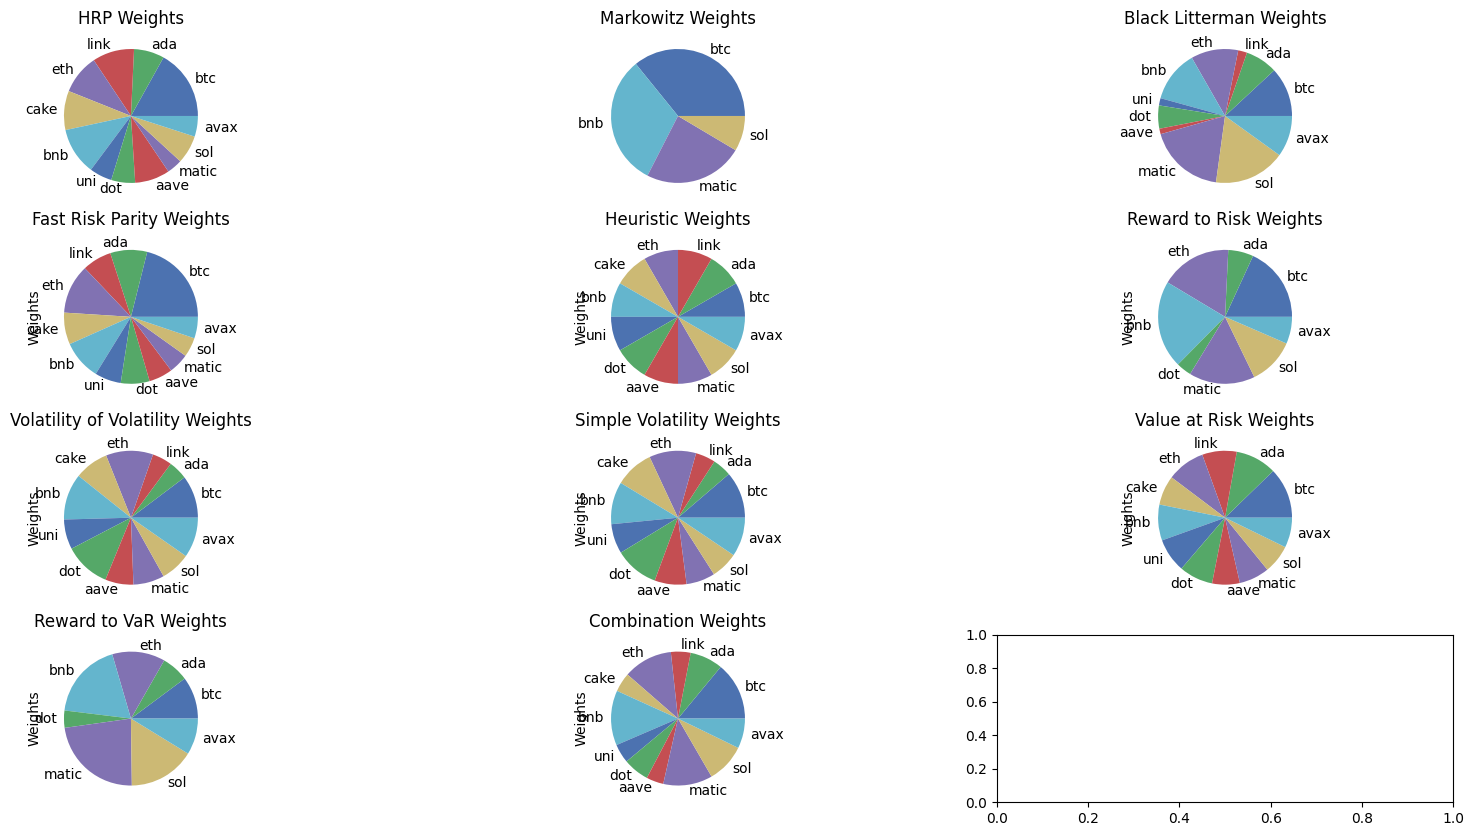

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

pd.Series(hrp_weights).plot.pie(ax=axs[0][0]);
axs[0][0].set_title('HRP Weights')

pd.Series(markowitz_weights).plot.pie(ax=axs[0][1]);
axs[0][1].set_title('Markowitz Weights')

pd.Series(bl_weights).plot.pie(ax=axs[0][2]);
axs[0][2].set_title('Black Litterman Weights')

pd.Series(fast_rp_weights).plot.pie(ax=axs[1][0]);
axs[1][0].set_title('Fast Risk Parity Weights')

pd.Series(heuristic_weights).plot.pie(ax=axs[1][1]);
axs[1][1].set_title('Heuristic Weights')

pd.Series(rtr_weights).plot.pie(ax=axs[1][2]);
axs[1][2].set_title('Reward to Risk Weights')

pd.Series(vov_weights).plot.pie(ax=axs[2][0]);
axs[2][0].set_title('Volatility of Volatility Weights')

pd.Series(vo_weights).plot.pie(ax=axs[2][1]);
axs[2][1].set_title('Simple Volatility Weights')

pd.Series(var_weights).plot.pie(ax=axs[2][2]);
axs[2][2].set_title('Value at Risk Weights')

pd.Series(rtvar_weights).plot.pie(ax=axs[3][0]);
axs[3][0].set_title('Reward to VaR Weights')

pd.Series(combination_weights).plot.pie(ax=axs[3][1]);
axs[3][1].set_title('Combination Weights')


plt.show()

/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/markowitz.py:136: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


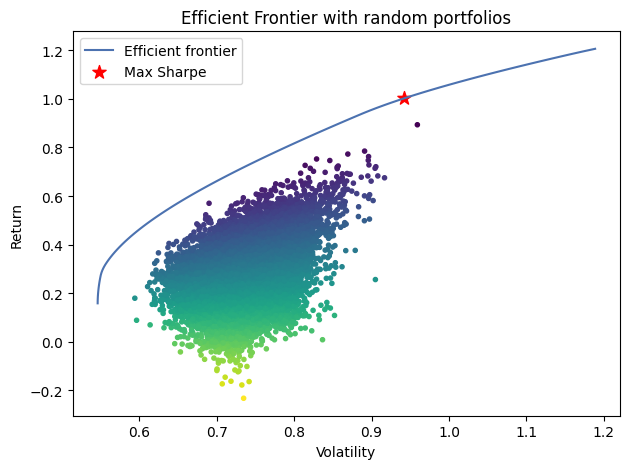

In [9]:
markowitz.plot_frontier()

In [10]:
from portfolio_optimization.portfolio import weight_diff

diffs = weight_diff(markowitz_weights, hrp_weights, threshold=0.05)
print(len(diffs))
diffs

8


[('btc', 'Sell', 0.15485106696461462),
 ('link', 'Buy', 0.08266417831037334),
 ('cake', 'Buy', 0.0772863819790618),
 ('ada', 'Buy', 0.06010526401951395),
 ('eth', 'Buy', 0.07846507706537666),
 ('matic', 'Sell', 0.165811294190834),
 ('bnb', 'Sell', 0.1654429519763606),
 ('aave', 'Buy', 0.0689454771668754)]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 20639.16206773924
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 25168.315308152654
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1142031587739741e-06
            Iterations: 38
            Function evaluations: 313
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: 75573.62412021348
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 105053.13502164686
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 139353.04384550435
            Iterations: 5
            Function evaluatio

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_fre

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.4427544018376673e-06
            Iterations: 42
            Function evaluations: 346
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176284.0203491822
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 246070.4499408345
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 379022.4787417358
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 678379.1970754456
            Iterations: 5
            Function evaluations:

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_fre

Optimization terminated successfully    (Exit mode 0)
            Current function value: 763996.1773957382
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 968514.7858010075
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1082799.8242483847
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1116390.6137108533
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1234457.1310682949
            Iterations: 5
            Function evaluations: 1

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.255033747808879e-08
            Iterations: 25
            Function evaluations: 322
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1184243.439626585
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.154028400336755e-09
            Iterations: 26
            Function evaluations: 347
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 883133.7479872145
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 725289.5794782066
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.631211846710463e-09
            Iterations: 26
            Function evaluations: 336
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 586116.4450342825
            Iterations: 5
            Function eva

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 442461.49955300067
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.0096486455052447e-09
            Iterations: 28
            Function evaluations: 361
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 490428.7669263386
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.40557295268563e-09
            Iterations: 35
            Function evaluations: 488
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 654951.4099671923
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 711330.6932450141
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 729627.4574292931
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.372580751015336e-09
            Iterations: 28
            Function evaluations: 388
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 691838.5502465928
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 609480.057393097
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 478741.9201885269
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 399622.29493766447
            Iterations: 5
            Function evaluation

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_fre

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.695695876032469e-09
            Iterations: 26
            Function evaluations: 362
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 298221.5763425528
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 232517.70507872713
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.355609210960635e-09
            Iterations: 26
            Function evaluations: 362
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 243882.61614999583
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 245097.0067118693
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1363980112858296e-09
            Iterations: 27
            Function evaluations: 374
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 368939.58152381965
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Finished processing Heuristic


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.555567273186728e-09
            Iterations: 28
            Function evaluations: 393
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.082113542104282e-09
            Iterations: 29
            Function evaluations: 401
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 538144.4629297032
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 553554.5430763605
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 464114.4097796989
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 393999.38562949025
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 342783.055105616
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6173629344676664e-09
            Iterations: 40
            Function evaluations: 547
            Gradient evaluations: 40
Optimization terminated successfully    (Exit mode 0)
            Current function value: 314568.4399082031
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 314186.605630867
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 316501.31679032184
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 339908.4793542332
            Iterations: 5
            Function evaluatio

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.382897601392922e-09
            Iterations: 34
            Function evaluations: 468
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.5509709544026503e-09
            Iterations: 33
            Function evaluations: 455
            Gradient evaluations: 33


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.955156758617538e-09
            Iterations: 28
            Function evaluations: 392
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 490278.9529856518
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 435058.1863577573
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 339101.97352802596
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 241897.52803236665
            Iterations: 5
            Function evaluati

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 51048.43769093729
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Finished processing Fast Risk Parity
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.066362165421395e-10
            Iterations: 28
            Function evaluations: 382
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 122641.0336360244
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 155594.84932508966
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.0981019699897234e-09
            Iterations: 26
            Function evaluations: 359
            Gradient evaluations: 26


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3850718621104342e-09
            Iterations: 27
            Function evaluations: 374
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 359786.8265263982
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 425674.6501381068
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 32030.060381477746
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 517354.8083835042
            Iterations: 5
            Function evaluati

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1271485878485497e-09
            Iterations: 28
            Function evaluations: 383
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.0838626420511027e-09
            Iterations: 30
            Function evaluations: 410
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: 173746.1722319154
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 117252.34584137138
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 96085.03418915033
            Iterations: 5
            Function 

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3815398334545217e-10
            Iterations: 32
            Function evaluations: 428
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4515721687275083e-10
            Iterations: 29
            Function evaluations: 390
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17348.20926716927
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17434.57309725175
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2925912672235488e-10
            Iterations: 34
            Function evaluations: 454
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.552915675711173e-10
            Iterations: 37
            Function evaluations: 494
            Gradient evaluations: 37


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: 25080.5012447155
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 28668.351643798844
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.484989005345723e-10
            Iterations: 32
            Function evaluations: 429
            Gradient evaluations: 32
Finished processing Simple Volatility
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.4476964386026424e-10
            Iterations: 32
            Function evaluations: 427
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17255.362467026756
            Iterations:

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.988234590954141e-10
            Iterations: 33
            Function evaluations: 440
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16904.37295648684
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17297.01043295196
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14846.30584015742
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6685367245426562e-10
            Iterations: 29
            Function evaluations: 389
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.074297875638537e-10
            Iterations: 29
            Function evaluations: 390
            Gradient evaluations: 29


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.110701517920824e-10
            Iterations: 31
            Function evaluations: 416
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.776426005860014e-10
            Iterations: 29
            Function evaluations: 389
            Gradient evaluations: 29


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_fre

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.011772137137975e-10
            Iterations: 30
            Function evaluations: 403
            Gradient evaluations: 30
Finished processing Reward to Risk
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.146221356447166e-10
            Iterations: 28
            Function evaluations: 376
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58753.97446913089
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58822.944816808056
            Iterations: 5

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo


            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 65638.20169465731
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 79630.54272962203
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 89553.59606425777
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 95771.88348635192
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 106862.9

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.636023954586508e-10
            Iterations: 30
            Function evaluations: 404
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: 93898.4402503937
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 78233.2566147861
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58162.92160134615
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 50235.29245683613
            Iterations: 5
            Function evaluations:

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.654089189090755e-10
            Iterations: 32
            Function evaluations: 428
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 33400.54464535018
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 33853.74693279363
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 32398.248683566573
            Iterations: 5
            Function evaluations: 13
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 23474.936428079214
            Iterations: 5
            Function evaluati

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Finished processing HRP


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Finished processing Value At Risk


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

Finished processing Markowitz


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is differ

Finished processing Reward to VaR


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is differ

Sum of raw weights is 0.0, but expected value is 1.
Skipping rebalance on 2023-08-06 due to insufficient data.
Finished processing BL
Finished processing Combination


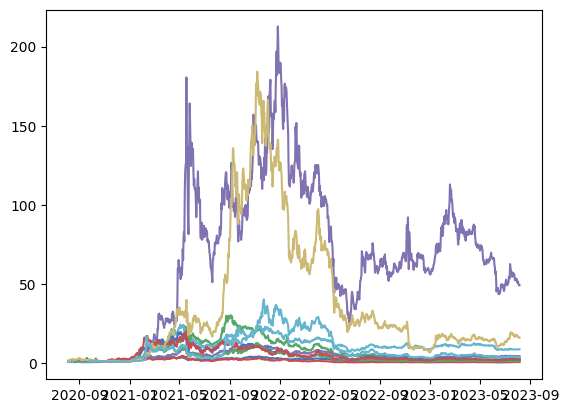

In [11]:
from portfolio_optimization.portfolio.Portfolio import Portfolio
from portfolio_optimization.backtesting.Backtesting import Backtest
from dateutil.relativedelta import relativedelta

# The portfolio starts
start_date_portfolio = df.index[0] + relativedelta(months=3)

initial_bid = 1000

porfolio_hrp = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=HRPOptimization,
)

portfolio_markowitz = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Markowitz,
)

portfolio_bl = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=BlackLitterman,
    mcaps=mcaps.loc[start_date_portfolio],
)

portfolio_parity = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RiskParity,
)

portfolio_fast_parity = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=FastRiskParity,
)

portfolio_default = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Heuristic,
)

portfolio_rtr = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RewardToRisk,
)

portfolio_vov = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=VolatilityOfVolatility,
)

portfolio_vo = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=SimpleVolatility,
)

portfolio_var = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=ValueAtRisk,
)

portfolio_rvar = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RewardToVaR,
)

portfolio_combination = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Combination,
)

backtest = Backtest(
    portfolios={
        "HRP": porfolio_hrp,
        "Markowitz": portfolio_markowitz,
        "BL": portfolio_bl,
        "Risk Parity": portfolio_parity,
        "Fast Risk Parity": portfolio_fast_parity,
        "Heuristic": portfolio_default,
        "Reward to Risk": portfolio_rtr,
        "Volatility of Volatility": portfolio_vov,
        "Simple Volatility": portfolio_vo,
        "Value At Risk": portfolio_var,
        "Reward to VaR": portfolio_rvar,
        "Combination": portfolio_combination,
    },
    start_date=start_date_portfolio,
    end_date=df.index[-1],
    rebalance_frequency="1W",
    data=df,
    mcaps=mcaps,
)

perfs = backtest.run_backtest(look_back_period=120, look_back_unit="D")

# Plot portfolio value over time using matplotlib
import matplotlib.pyplot as plt

df_normalized = df / df.loc[start_date_portfolio]
plt.plot(df_normalized)


In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import GridBox 

# Calculate the first date of the portfolio. The start date is the minimum date of the portfolio_value DataFrame within the `perfs` object. So we just reduce the perfs object to the portfolio_value DataFrame, and then get the minimum date.
start_date_portfolio = min(performance.portfolio_value['Portfolio Value'].index.min() for performance in perfs)


# Normalize prices of each asset at the start date of the portfolio
df_normalized = df / df.loc[start_date_portfolio]

# Calculate the daily equal-weighted return  
# df['equal_weighted'] = df_normalized.mean(axis=1)

# Normalize our portfolio and equally-weighted series to 100 at the start date of the portfolio
portfolio_normalized = pd.concat({performance.name: performance.portfolio_value['Portfolio Value'].loc[start_date_portfolio:] for performance in perfs}, axis=1)

# convert the index to a list of dates, which will be used for the Slider
_dates = [date for performance in perfs for date in performance.portfolio_value['Portfolio Value'].index]
dates = list(dict.fromkeys(_dates))
_rebalance_dates = [rebalance_date for performance in perfs for rebalance_date in performance.rebalance_dates if rebalance_date >= start_date_portfolio]
rebalance_dates = list(dict.fromkeys(_rebalance_dates))

In [13]:
# create a function to update the chart
def update(rebalance_date_index, main_portfolio=0):
    clear_output(wait=True)
        
    selected_date = rebalance_dates[rebalance_date_index]
    
    # Adjust the date_index to the closest rebalance date
    date_index = dates.index(selected_date)
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[1, 0]) # for you normalized performance comparison
    ax3 = plt.subplot(gs[0, 0]) # put the ax1 graph below
    ax4 = plt.subplot(gs[:, 1]) # add a new bar graph showing the backtest.portfolio_holdings on the left of ax2
    ax2 = plt.subplot(gs[0, 1]) # for your pie chart of portfolio composition

    # plot portfolio values on ax1
    portfolio_names = list(p.name for p in perfs)
    ax1.plot(portfolio_normalized.index, portfolio_normalized, label=portfolio_names)
    
    for rebalance_date in rebalance_dates:
        if rebalance_date >= start_date_portfolio:
            ax1.axvline(x=rebalance_date, color='gray', linestyle='--')  

    ax1.axvline(x=selected_date, color='blue', linestyle='-')  # the selected date bar

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Normalized Value")
    ax1.legend()
    ax1.set_title("Performance comparison (selected blue line)")

    # create portfolio composition pie chart on ax2
    selected = perfs[main_portfolio].portfolio_compositions.iloc[rebalance_date_index]
    # filter out rows where value is 0
    selected = selected[selected != 0]

    labels = selected.keys().tolist()
    sizes = selected.replace(np.nan, 0).tolist()

    ax2.pie(sizes, labels=labels)
    ax2.set_title(str(dates[date_index]))

    portfolio_value = perfs[main_portfolio].portfolio_holdings.iloc[rebalance_date_index] * df.loc[selected_date]


    # plot portfolio_value instead of portfolio_holdings
    portfolio_value.plot(ax=ax3, kind='bar')
    ax3.set_title('Portfolio Value in Dollars')

    plt.show()

# create a slider for dates
date_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(rebalance_dates)-1 if len(rebalance_dates) > 0 else 0,
    step=1,
    description='Date Index:',
    continuous_update=True
)

pf_index = widgets.Dropdown(
    options=[(p.name, i) for i, p in enumerate(perfs)],
    value=0,
    description='Portfolio:',
    disabled=False,
)


# link the date_slider to the update function
widgets.interactive(update, rebalance_date_index=date_slider, main_portfolio=pf_index)

interactive(children=(IntSlider(value=0, description='Date Index:', max=143), Dropdown(description='Portfolio:…

# Portfolio Rating
> Using Sharpe ratio to evaluate the performance of a portfolio

In [14]:
returns = portfolio_normalized.pct_change().apply(lambda x: np.log(1+x))


mean_returns = returns.mean()
std_returns = returns.std()

# Assume a risk free rate of 0.01, though this could be any risk free rate of your choice
risk_free_rate = 0.054

#  Calculate the Sharpe Ratio for each asset
sharpe_ratios = (mean_returns - risk_free_rate) / std_returns

# Sort the assets by their sharpe ratios
ranked_assets = sharpe_ratios.sort_values(ascending=False)

ranked_assets

Markowitz                  -0.967984
Risk Parity                -1.035159
Reward to VaR              -1.058890
Heuristic                  -1.093803
Simple Volatility          -1.102815
Volatility of Volatility   -1.104032
Reward to Risk             -1.118436
BL                         -1.122845
Combination                -1.125514
Value At Risk              -1.130048
HRP                        -1.193247
Fast Risk Parity           -1.196857
dtype: float64

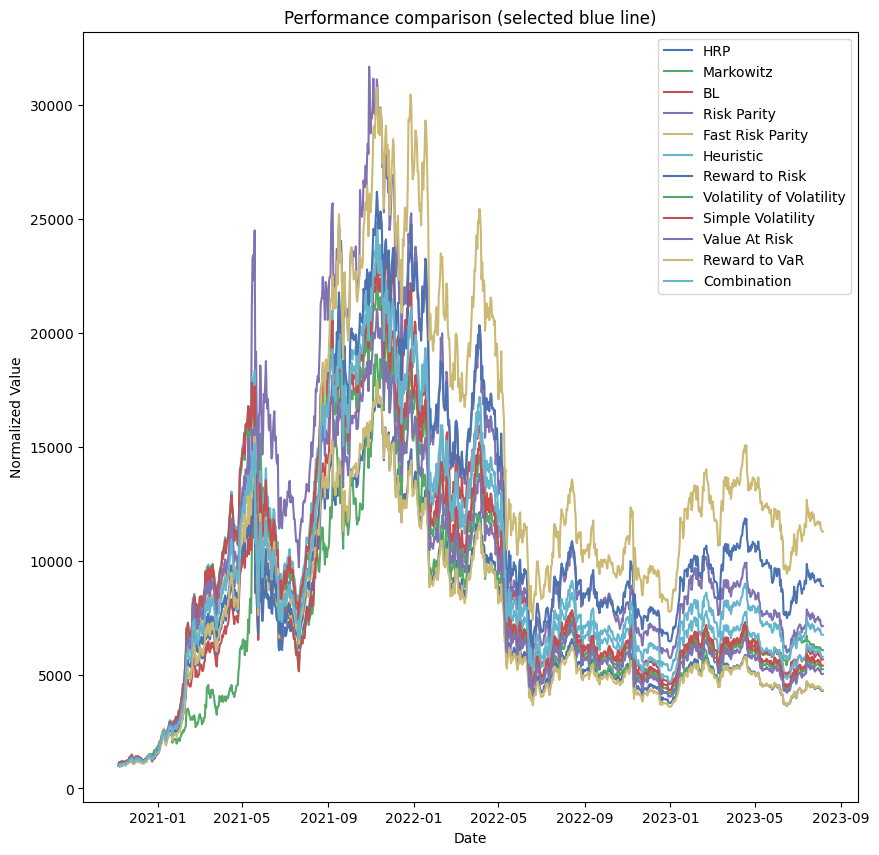

In [15]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111, ylabel="Portfolio value in $")

# plot portfolio values on ax1
portfolio_names = list(p.name for p in perfs)
ax1.plot(portfolio_normalized.index, portfolio_normalized, label=portfolio_names)
ax1.set_xlabel("Date")
ax1.set_ylabel("Normalized Value")
ax1.legend()
ax1.set_title("Performance comparison (selected blue line)")
# Save as PDF
plt.savefig(f"./out/{backtest.rebalance_frequency}/portfolio_value.pdf", bbox_inches="tight")

In [16]:
df_normalized.to_excel('~/Downloads/df_normalized.xlsx', index=False)